## 1. Introduction

#### 1.1 Background Information

According to Forbes, approximately 66% of users between the age of 18 and 35 years old shows stronger loyalty to brands with strong social media presence (Shaw, 2018). Since they are whose with highest buying power, it is crucial for companies to understand how to engage their customers effectively on social media (Sheerin et al., 2020). Specificly, we will look into key marketing metrics on Facebook platform, **determine which is the best proxy for consumer interaction and find out what type of content is the most effective to engage users.**

#### 1.2 Dataset Description

The dataset is a compilation of 500 different facebook posts by a cosmetics brand. Each observation includes important information on the post including the following variables of interest for this report:

- **Type**: The type of facebook post (Video, Photo, Status and Link).
- **Lifetime Impressions**: The number of times a post is displayed on Facebook users' personal feed. The post does not have to be clicked to count as an impression.
- **Lifetime Consumptions**: The total number of clicks anywhere on the post. Each click, even on the same post, is counted as one.

#### 1.3 Project Objective

We decide that the Lifetime Consumptions/Lifetime Impressions ratio will be the best proxy for user engagement. This metric essentially tells you the interaction rate of a consumer once they see the content on their feed.

Our goal is to find **which type of Facebook content delivers the highest Consumptions/Impressions ratio and is there enough statistical evidence to pinpoint which type does the best job?**

## 2. Methods and Results

#### 2.1 Reading the Data

In [1]:
# Load the required libraries
library(tidyverse)
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(broom)
set.seed(1)

# Here we read the data set straight from the web
# The original source is linked here (https://archive.ics.uci.edu/ml/datasets/Facebook+metrics)
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)
data <- read_delim(unz(temp, "dataset_Facebook.csv"), delim=";")
unlink(temp)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 500 Columns: 19

── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Type
dbl (18): Page total likes, Category, Post Month, Post Weekday, Post Hour, P...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



#### 2.2 Cleaning the Data

In [2]:
# First remove spaces from the column names
names(data)<-make.names(names(data),unique = TRUE)

# Select only the variables of interest and calculate the ratio of consumptions/impressions
data_selected = data %>%
    select(Type, Lifetime.Post.Total.Impressions, Lifetime.Post.Consumptions) %>%
    mutate(ratio=Lifetime.Post.Consumptions/Lifetime.Post.Total.Impressions) %>%
    filter(!is.na(Type))

# Assign new more manageable column names
names(data_selected) <- c("Type", "LifetimeImpressions", "LifetimeConsumptions", "ConsumptionsOverImpressions")

# Here we break the dataset apart by type for later use
data_photo = data_selected %>%
    filter(Type == "Photo")
data_status = data_selected %>%
    filter(Type == "Status")
data_link = data_selected %>%
    filter(Type == "Link")
data_video = data_selected %>%
    filter(Type == "Video")

# Preview the clean dataset
head(data_selected)

Type,LifetimeImpressions,LifetimeConsumptions,ConsumptionsOverImpressions
<chr>,<dbl>,<dbl>,<dbl>
Photo,5091,159,0.03123159
Status,19057,1674,0.08784174
Photo,4373,154,0.03521610
Photo,87991,1119,0.01271721
Photo,13594,580,0.04266588
Status,20849,1389,0.06662190


#### 2.3 Data Summary

In [3]:
# Here we will provide a summary of the dataset including means, minimums, and maximums of the variables of interest
data_summary <- data_selected %>%
    group_by(Type) %>%
    summarise(MeanImpressions = mean(LifetimeImpressions), MinImpressions = min(LifetimeImpressions),
              MaxImpressions = max(LifetimeImpressions),  MeanConsumptions = mean(LifetimeConsumptions),
              MinConsumptions = min(LifetimeConsumptions), MaxConsumptions = max(LifetimeConsumptions), 
              MeanRatio = mean(ConsumptionsOverImpressions), Num = sum(Type == Type))
data_summary

#Select MeanImpressions and MeanConsumptions and put them in the same column for data_summary_plot
data_summary_longer <- data_summary %>%
    select(Type, MeanImpressions, MeanConsumptions) %>%
    pivot_longer(cols=c('MeanImpressions', 'MeanConsumptions'), names_to='variable', values_to='value')

data_summary_longer

Type,MeanImpressions,MinImpressions,MaxImpressions,MeanConsumptions,MinConsumptions,MaxConsumptions,MeanRatio,Num
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Link,28725.45,3094,229733,374.0909,26,1345,0.02594883,22
Photo,28994.50,570,1110282,1299.0258,9,19779,0.12364624,426
Status,24244.47,7509,59964,2838.8667,112,9237,0.10865636,45
Video,102622.43,30235,277100,2600.1429,539,7327,0.04637671,7


Type,variable,value
<chr>,<chr>,<dbl>
Link,MeanImpressions,28725.4545
Link,MeanConsumptions,374.0909
Photo,MeanImpressions,28994.4977
Photo,MeanConsumptions,1299.0258
Status,MeanImpressions,24244.4667
Status,MeanConsumptions,2838.8667
Video,MeanImpressions,102622.4286
Video,MeanConsumptions,2600.1429


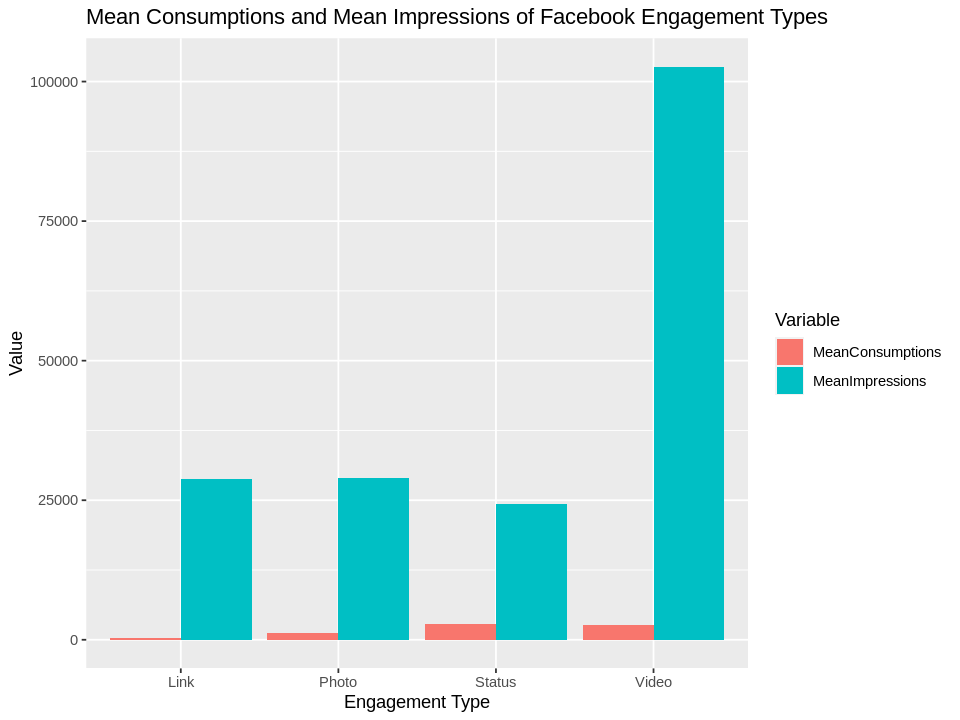

In [4]:
options(repr.plot.width = 8, repr.plot.height = 6)

# A side by side histogram of consumptions and impressions separated by type
data_summary_plot <- data_summary_longer %>%
    ggplot(aes(x=Type, y=value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x = "Engagement Type", y = "Value", fill = "Variable") +
    ggtitle("Mean Consumptions and Mean Impressions of Facebook Engagement Types")
data_summary_plot

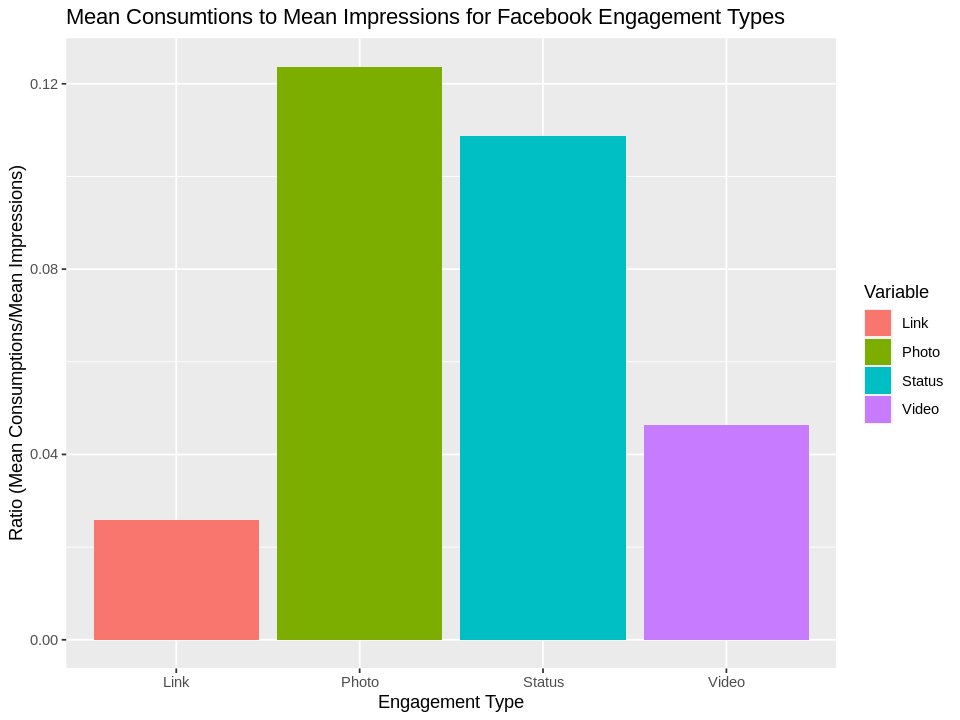

In [5]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Mean Consumptions over Mean Impressions ratio plot separated by type
data_ratio_plot <- data_summary %>%
    ggplot(aes(x=Type, y=MeanRatio, fill=Type)) +
    geom_bar(stat='identity', position='dodge') + 
    labs(x = "Engagement Type", y = "Ratio (Mean Consumptions/Mean Impressions)", fill = "Variable") +
    ggtitle("Mean Consumtions to Mean Impressions for Facebook Engagement Types")
data_ratio_plot

#### 2.4 Plot Observations

As illustrated above, the impressions far outweigh the consumptions which means on average Facebook displays a post far more often than that post gets clicked. Another key insight is that Videos seem to be shared much more often across Facebook as their mean impressions are by far the highest. However this does not seem to affect that of consumptions, which demonstrates why the Consumption/Impression ratio is more rational than using a single metric.

From an eye test, we can **make preliminary assumption that Photo and Status has higher Consumption/Impression ratio than Link and Video type of content.**

#### 2.5 Bootstraping

In this section we will calculate 90% confidence intervals for the mean ratio of each type of post. To do this we will sample 1000 times from the original sample using sizes calculated in part 2.3 Data Summary. We also plot the bootstrap distributions to visualize their spread.

In [6]:
# Below we take a bootstrap of 1000 resamples for each type of post (Photo, Video, etc.) The sizes were precalculated in the main summary
# table and were used again.

bootstrap_photo <- data_photo %>% 
    rep_sample_n(reps = 1000, size = 426, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_status <- data_status %>% 
    rep_sample_n(reps = 1000, size = 45, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_video <- data_video %>% 
    rep_sample_n(reps = 1000, size = 7, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_link <- data_link %>% 
    rep_sample_n(reps = 1000, size = 22, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


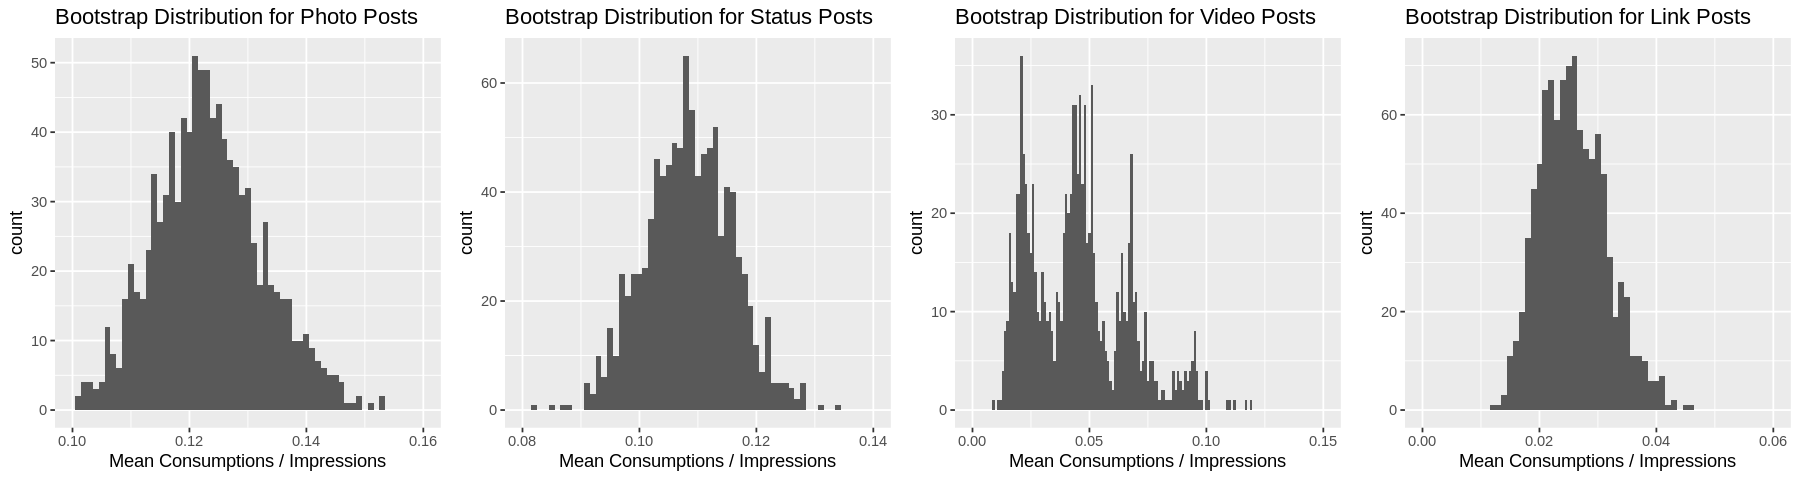

In [7]:
options(repr.plot.width = 15, repr.plot.height = 4)

# in this cell we will plot all bootstrap distributions to get an idea of the originial distributions
bootstrap_photo_plot <- bootstrap_photo %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_status_plot <- bootstrap_status %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_video_plot <- bootstrap_video %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_link_plot <- bootstrap_link %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

# Plot the bootstrap distributions side by side
plot_grid(bootstrap_photo_plot +
              labs(title = "Bootstrap Distribution for Photo Posts") +
              scale_x_continuous(limits = c(0.1,0.16)),
          bootstrap_status_plot +
              labs(title = "Bootstrap Distribution for Status Posts") +
              scale_x_continuous(limits = c(0.08,0.14)),
          bootstrap_video_plot +
              labs(title = "Bootstrap Distribution for Video Posts") +
              scale_x_continuous(limits = c(0,0.15)),
          bootstrap_link_plot +
              labs(title = "Bootstrap Distribution for Link Posts") +
              scale_x_continuous(limits = c(0,0.06)),
          ncol = 4)

#### 2.6 Calculating Uncertainty from Bootstrapping

In [8]:
# In this cell we calculate the 90% confidence interval for the original means using the bootstraps calculated previously

# Combine all bootstraps to one DF and calculate confidence intervals
Confidence_Interval <- bind_rows(mutate(bootstrap_photo, Type = "Photo"),
    mutate(bootstrap_status, Type = "Status"),
    mutate(bootstrap_video, Type = "Video"),
    mutate(bootstrap_link, Type = "Link")) %>%
    group_by(Type) %>%
    summarise(ci_lower = quantile(mean_ratio, 0.05),
              ci_upper = quantile(mean_ratio, 0.95)) %>%
    bind_cols(select(data_summary, MeanRatio))

Confidence_Interval

Type,ci_lower,ci_upper,MeanRatio
<chr>,<dbl>,<dbl>,<dbl>
Link,0.01751523,0.03580021,0.02594883
Photo,0.10876724,0.13981007,0.12364624
Status,0.09639651,0.12061863,0.10865636
Video,0.01697675,0.08688191,0.04637671


#### 2.7 Calculating Uncertainty using Asymptotics

In [9]:
mean_ratio_link <- data_summary %>%
    filter(Type == "Link") %>%
    pull(MeanRatio)
mean_ratio_link

mean_ratio_photo <- data_summary %>%
    filter(Type == "Photo") %>%
    pull(MeanRatio)
mean_ratio_photo

mean_ratio_status <- data_summary %>%
    filter(Type == "Status") %>%
    pull(MeanRatio)
mean_ratio_status

mean_ratio_video <- data_summary %>%
    filter(Type == "Video") %>%
    pull(MeanRatio)
mean_ratio_video

[1] 0.02594883

[1] 0.1236462

[1] 0.1086564

[1] 0.04637671

In [10]:
sd_link <- sd(data_link %>% pull(ConsumptionsOverImpressions))/sqrt(data_link %>% nrow())
sd_link

sd_photo <- sd(data_photo %>% pull(ConsumptionsOverImpressions))/sqrt(data_photo %>% nrow())
sd_photo

sd_status <- sd(data_status %>% pull(ConsumptionsOverImpressions))/sqrt(data_status %>% nrow())
sd_status

sd_video <- sd(data_video %>% pull(ConsumptionsOverImpressions))/sqrt(data_video %>% nrow())
sd_video

[1] 0.006044351

[1] 0.009180876

[1] 0.007663659

[1] 0.02331406

In [11]:
mean_ratio_link_ci <- tibble(
    lower_ci = qnorm(0.05, mean_ratio_link, sd_link),
    upper_ci = qnorm(0.95, mean_ratio_link, sd_link))
mean_ratio_link_ci

mean_ratio_photo_ci <- tibble(
    lower_ci = qnorm(0.05, mean_ratio_photo, sd_photo),
    upper_ci = qnorm(0.95, mean_ratio_photo, sd_photo))
mean_ratio_photo_ci

mean_ratio_status_ci <- tibble(
    lower_ci = qnorm(0.05, mean_ratio_status, sd_status),
    upper_ci = qnorm(0.95, mean_ratio_status, sd_status))
mean_ratio_status_ci

mean_ratio_video_ci <- tibble(
    lower_ci = qnorm(0.05, mean_ratio_video, sd_video),
    upper_ci = qnorm(0.95, mean_ratio_video, sd_video))
mean_ratio_video_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.01600676,0.03589091


lower_ci,upper_ci
<dbl>,<dbl>
0.108545,0.1387474


lower_ci,upper_ci
<dbl>,<dbl>
0.09605076,0.121262


lower_ci,upper_ci
<dbl>,<dbl>
0.008028496,0.08472493


**Analysis**

- Unsurprisingly the **confidence interval for Video is the largest**. This is because we have only 7 observations with the type video and as a result we need a wider confidence interval. 
- Surprisingly **Link has the smallest confidence interval even though we have the most observations of type Photo**. This could be a result of random chance in the bootstrapping samples.
- Since the **confidence interval for Photo and Status is clearly above the range of confidence interval for Link and Video**, we now have more conviction to say that these two are the more effective content types

#### 2.8 ANOVA Test

In order to examine if the type of post has an effect on the consumption / impression ratio we will run an ANOVA test on the data at a significance level of 5%. Because video type posts have such a small sample we will be omitting them from the hypothesis testing.
- Null Hypothesis: All post types have equal Consumptions over Impressions
- Alternative Hypothesis: At least one post type has a mean ratio different from the others

In [12]:
variance_overall <- data_selected %>%
    filter(Type != "Video") %>%
    group_by(Type) %>%
    summarise(var = var(ConsumptionsOverImpressions))
variance_overall

Type,var
<chr>,<dbl>
Link,0.000803752
Photo,0.035906890
Status,0.002642925


As we can see above the variances are far from equal. Thus we need to specify the var.equal argument in the oneway.test function to false to account for this.

In [13]:
anova_result <- oneway.test(ConsumptionsOverImpressions ~ Type,
    data = filter(data_selected, Type != "Video"),
    var.equal = FALSE) %>%
    tidy() %>%
    select(-method)
anova_result

Multiple parameters; naming those columns num.df, den.df



num.df,den.df,statistic,p.value
<dbl>,<dbl>,<dbl>,<dbl>
2,106.3503,55.92994,2.524082e-17


We can reject the null hypothesis at a significance level of 5% meaning that there is sufficient evidence to suggest a statistical difference between at least one pair of ratios.

#### 2.9 T Tests

In order to isolate the the differences we will be conducting T tests on the three types of posts (Photo, Link, Status) comparing them individually. For example we will compare Photo and link and then Photo and Status etc. Each test will share the Null and Alternative hypothesis listed below and be conducted at a 5% significance level.
- Null Hypothesis: The mean ratios are equal
- Alternative Hypothesis: The mean ratios are not equal

In [14]:
photo_link <- t.test(x = data_selected %>% filter(Type == "Photo") %>% pull(ConsumptionsOverImpressions),
                     y = data_selected %>% filter(Type == "Link") %>% pull(ConsumptionsOverImpressions),
                     alternative = "two.sided") %>%
                tidy()

photo_status <- t.test(x = data_selected %>% filter(Type == "Photo") %>% pull(ConsumptionsOverImpressions),
                     y = data_selected %>% filter(Type == "Status") %>% pull(ConsumptionsOverImpressions),
                     alternative = "two.sided") %>%
                tidy()

status_link <- t.test(x = data_selected %>% filter(Type == "Status") %>% pull(ConsumptionsOverImpressions),
                     y = data_selected %>% filter(Type == "Link") %>% pull(ConsumptionsOverImpressions),
                     alternative = "two.sided") %>%
                tidy()

t_test <- bind_rows(photo_link, photo_status, status_link) %>%
    add_column(Tested_Types = c("Photo Link", "Photo Status", "Status Link"))

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Tested_Types
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.09769741,0.1236462,0.02594883,8.888098,6.024997e-16,181.84920,0.076009272,0.11938554,Welch Two Sample t-test,two.sided,Photo Link
0.01498988,0.1236462,0.10865636,1.253429,2.114107e-01,215.05922,-0.008582179,0.03856194,Welch Two Sample t-test,two.sided,Photo Status
0.08270752,0.1086564,0.02594883,8.473765,4.761239e-12,63.93281,0.063208443,0.10220660,Welch Two Sample t-test,two.sided,Status Link


Above we see that we can reject the null hypothesis for both Photo Link and Status Link tests. This means that we expect a difference in the ratios of Photo and Link and between Status and Link posts whereas there is insufficient evidence to detect a similar difference between Photo and Status.

Finally as our original plan was to infer if a specific type of post was better than others we will be conducting two final T Tests on the pairs where a statistical difference was inferred (Photo and Link, Status and Link). Recall that a larger ratio means that a post is getting more clicks per exposure and is thus more effective at reaching the audience.

**Photo And Link**
- Null Hypothesis: The test ratio of photo posts equals that of link posts
- Alternative Hypothesis: The test ratio of photo posts is greater than that of link posts

**Status And Link**
- Null Hypothesis: The test ratio of Status posts equals that of link posts
- Alternative Hypothesis: The test ratio of Status posts is greater than that of link posts

In [15]:
photo_link_greater <- t.test(x = data_selected %>% filter(Type == "Photo") %>% pull(ConsumptionsOverImpressions),
                     y = data_selected %>% filter(Type == "Link") %>% pull(ConsumptionsOverImpressions),
                     alternative = "greater") %>%
                tidy()

status_link_greater <- t.test(x = data_selected %>% filter(Type == "Status") %>% pull(ConsumptionsOverImpressions),
                     y = data_selected %>% filter(Type == "Link") %>% pull(ConsumptionsOverImpressions),
                     alternative = "greater") %>%
                tidy()
t_test_greater <- bind_rows(photo_link_greater, status_link_greater) %>%
    add_column(Tested_Types = c("Photo Link", "Status Link"))
t_test_greater

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Tested_Types
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.09769741,0.1236462,0.02594883,8.888098,3.012498e-16,181.84920,0.0795247,Inf,Welch Two Sample t-test,greater,Photo Link
0.08270752,0.1086564,0.02594883,8.473765,2.380620e-12,63.93281,0.0664170,Inf,Welch Two Sample t-test,greater,Status Link


As we can see in both cases we are able to reject the null at a significance level of 5%. This means there is evidence to suggest that both photo and status type posts are better at reaching the audience than link posts.

## 3. Methods: Plan

#### 3.1 Methods & Plan

Our project aims to tackle a critical issue in digital advertising, and we aim to provide a more in-depth perspective built on research paper by Moro (Moro et al., 2016). We have made taken steps to select a representative data set, clean & wrangle data and identify the most relevant variable to analyze. Through basic data exploratory and bootstrapping, the preliminary assumption have aligned with the statistical evidence. 
  
  However, since there are variance between our bootstrap estimates and population parameter, our charts and estimates will not suffice. Therefore, we plan to communicate the uncertainty of our estimates by constructing and visualizing 95% confidence intervals for each content type. We then will proceed with hypothesis testing to get the statistical evidence to confirm that Photo and Status are the most effective content types.

#### 3.2 Implication of Research

 Understanding which type of content will engage customers the most will allow companies to best allocate their advertising budget. There are two future questions to analyze more:
   - Would different types of products being advertise (such as clothes, food, education) have an effect on Consumption/Impression ratio?
   - Would video and photo still be the most effective type of content on other platforms? For example, we have Instagram story, TikTok short videos and even LinkedIn advertisement. All can change the dynamics of a social media platform and thus affect what type would work best.

## 4. Discussion

#### 4.1 Implication of Research

Our analysis of the 500 different Facebook posts (cosmetics brand) showed that the types of Photos and Status have a higher Consumption/Impression ratio, which are relatively more effective ways to attract consumers compared with other types of content. As analyzed in the previous sections, we focused on four different content delivers involving Video, Photo, Status, and Link, and we found that the mean ratios (consumptions over impressions) of Photo and Status are both greater than 0.1, which are 0.1236 and 0.1087 respectively. Their results are much higher than the other two types. After finding these mean ratios of the dataset, our group also calculated their confidence interval by bootstrapping. Although the observations of the photo are most in our dataset, confidence intervals for Photo and Status are clearly above the range of confidence intervals for Link and Video. We are 95% confident that the mean ratios of the photo fall between 0.1088 and 0.1398, and the status’ falls between 0.0964 and 0.1206. In addition, to make our research more reliable, an ANOVA test at a significance level of 5% was applied, which can help determine if the different types of posts have different effects on the consumption/impression ratio. The null hypothesis is all post types have an equal mean ratio while the alternative hypothesis is at least one post type has a mean ratio different from the others. Our group found that the p-value is 2.524082e-17, therefore, the null hypothesis can be rejected at a significance level of 5%. From our findings, we can conclude that there is sufficient evidence to suggest a statistical difference between at least one pair of ratios. Continually, we conducted two T-tests on two pairs: Photo and Link, Status and Link, to determine if there is a significant difference between the means of the two groups. Since their p-values are 3.012498e-16 and 2.380620e-12, our group can reject the null at a significance level of 5%. Therefore, there is sufficient evidence to suggest that both photo and status type posts are better at reaching the audience than link posts. However, we cannot get the difference between photos and status. Our results were what we expected to find, which lead to the determination of photos and status have a relatively higher Consumptions/Impressions ratio and there is enough statistical evidence to pinpoint they are more effective to attract consumers when advertising cosmetics. Our findings can lead to a positive impact on suggesting to cosmetics companies that the photo and status contents are the most effective ways to advertise their products and allow them to best allocate their advertising budget.

#### 4.2 Limitation

The sample size of the video-type posts is too small, which only has seven observations. Since small simple size can increase the margin of error and render the study meaningless, this type of Facebook content deliver cannot play a constructive role when analysis We got the highest confidence interval for videos and our group decided to omit them from the hypothesis testing. 

#### 4.3 Future questions

There are two future questions to analyze more:
- Would different types of products being advertise (such as clothes, food, education) have an effect on Consumption/Impression ratio?
- Would video and photo still be the most effective type of content on other platforms? For example, we have Instagram story, TikTok short videos and even LinkedIn advertisement. All can change the dynamics of a social media platform and thus affect what type would work best.

## 5. References

1. Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. *Journal of Business Research*, 69(9), 3341-3351. https://doi.org/10.1016/j.jbusres.2016.02.010 
2. Shaw, A. (2018). How social media can move your business forward. *Forbes*. https://www.forbes.com/sites/forbescommunicationscouncil/2018/05/11/how-social-media-can-move-your-business-forward/?sh=f3f47264cf2b
3. Sheerin, ., Patel, S., Oundjian, A. & Leon, H. (2020). Digital marketers race to meet the needs of a new era. *Boston Consulting Group*. https://www.bcg.com/publications/2020/digital-marketers-race-to-meet-the-needs-of-growing-online-agendas
